# Base Code

Reference

- https://github.com/argusswift/YOLOv4-pytorch

## Train

In [1]:
import os
import numpy as np
import random

In [2]:
from model.build_model import Build_Model
from model.loss.yolo_loss import YoloV4Loss

In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

In [4]:
import utils.datasets as data
from utils import cosine_lr_scheduler
import utils.data_augment as dataAug
import utils.tools as tools

In [5]:
import config.yolov4_config as cfg

In [7]:
# def detection_collate(batch):
#     targets = []
#     imgs = []
#     for sample in batch:
#         imgs.append(sample[0])
#         targets.append(sample[1])
#     return torch.stack(imgs, 0), targets

In [8]:
# GPU device
# Check GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device: ", device)

Device:  cpu


In [9]:
start_epoch = 0
best_mAP = 0.0

epochs = 1
eval_epoch = 2

batch_size = 1

In [10]:
# weight_path = 'weight/mobilenetv2.pth'

weight_path = 'weight/yolov4.weights'

## Dataset

In [11]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision
import cv2

import pandas as pd

In [12]:
# bounding box 좌표 변경하기
def cvt_coordinate(center_x, center_y, w, h):
    '''
    start_x, start_y: 시작 꼭짓점 좌표 (x, y)
    end_x, end_y: 종료 꼭짓점 좌표 (x, y)
    '''
    start_x, end_x = center_x - (w//2), center_x + (w//2)
    start_y, end_y = center_y - (h//2), center_y + (h//2)

    return [start_x, start_y, end_x, end_y]

## DataSet

In [12]:
class BuildDataset(Dataset):
    def __init__(self, path, img_size=416):
        self.img_size = img_size
        self.classes = ['1', '2', '3', '4', '5', '6']
        self.num_classes = len(self.classes)
        self.class_to_id = dict(zip(self.classes, range(self.num_classes)))
        anno_path = path
        with open(anno_path, "r") as f:
            annotations = list(filter(lambda x: len(x) > 0, f.readlines()))
        
        self.__annotations = annotations
        
    def __len__(self):
        return len(self.__annotations)
    
    def __getitem__(self, item):
        img_org, bboxes_org = self.__parse_annotation(self.__annotations[item])
        img_org = img_org.transpose(2, 0, 1)  # HWC->CHW
        
        item_mix = random.randint(0, len(self.__annotations) - 1)
        img_mix, bboxes_mix = self.__parse_annotation(
            self.__annotations[item_mix]
        )
        img_mix = img_mix.transpose(2, 0, 1)

        img, bboxes = dataAug.Mixup()(img_org, bboxes_org, img_mix, bboxes_mix)
        del img_org, bboxes_org, img_mix, bboxes_mix

        (
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        ) = self.__creat_label(bboxes)

        img = torch.from_numpy(img).float()
        label_sbbox = torch.from_numpy(label_sbbox).float()
        label_mbbox = torch.from_numpy(label_mbbox).float()
        label_lbbox = torch.from_numpy(label_lbbox).float()
        sbboxes = torch.from_numpy(sbboxes).float()
        mbboxes = torch.from_numpy(mbboxes).float()
        lbboxes = torch.from_numpy(lbboxes).float()

        return (
            img,
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        )
        
    
    def __parse_annotation(self, annotation):
        """
        Data augument.
        :param annotation: Image' path and bboxes' coordinates, categories.
        ex. [image_path xmin,ymin,xmax,ymax,class_ind xmin,ymin,xmax,ymax,class_ind ...]
        :return: Return the enhanced image and bboxes. bbox'shape is [xmin, ymin, xmax, ymax, class_ind]
        """
        anno = annotation.strip().split(" ")

        img_path = anno[0]
        img = cv2.imread(img_path)  # H*W*C and C=BGR
        assert img is not None, "File Not Found " + img_path
        bboxes = np.array(
            [list(map(float, box.split(","))) for box in anno[1:]]
        )

        img, bboxes = dataAug.RandomHorizontalFilp()(
            np.copy(img), np.copy(bboxes), img_path
        )
        img, bboxes = dataAug.RandomCrop()(np.copy(img), np.copy(bboxes))
        img, bboxes = dataAug.RandomAffine()(np.copy(img), np.copy(bboxes))
        img, bboxes = dataAug.Resize((self.img_size, self.img_size), True)(
            np.copy(img), np.copy(bboxes)
        )

        return img, bboxes
    
    def __creat_label(self, bboxes):
        """
        Label assignment. For a single picture all GT box bboxes are assigned anchor.
        1、Select a bbox in order, convert its coordinates("xyxy") to "xywh"; and scale bbox'
           xywh by the strides.
        2、Calculate the iou between the each detection layer'anchors and the bbox in turn, and select the largest
            anchor to predict the bbox.If the ious of all detection layers are smaller than 0.3, select the largest
            of all detection layers' anchors to predict the bbox.

        Note :
        1、The same GT may be assigned to multiple anchors. And the anchors may be on the same or different layer.
        2、The total number of bboxes may be more than it is, because the same GT may be assigned to multiple layers
        of detection.

        """

        anchors = np.array(cfg.MODEL["ANCHORS"])
        strides = np.array(cfg.MODEL["STRIDES"])
        train_output_size = self.img_size / strides
        anchors_per_scale = cfg.MODEL["ANCHORS_PER_SCLAE"]

        label = [
            np.zeros(
                (
                    int(train_output_size[i]),
                    int(train_output_size[i]),
                    anchors_per_scale,
                    6 + self.num_classes,
                )
            )
            for i in range(3)
        ]
        for i in range(3):
            label[i][..., 5] = 1.0

        bboxes_xywh = [
            np.zeros((150, 4)) for _ in range(3)
        ]  # Darknet the max_num is 30
        bbox_count = np.zeros((3,))

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = int(bbox[4])
            bbox_mix = bbox[5]

            # onehot
            one_hot = np.zeros(self.num_classes, dtype=np.float32)
            one_hot[bbox_class_ind] = 1.0
            one_hot_smooth = dataAug.LabelSmooth()(one_hot, self.num_classes)

            # convert "xyxy" to "xywh"
            bbox_xywh = np.concatenate(
                [
                    (bbox_coor[2:] + bbox_coor[:2]) * 0.5,
                    bbox_coor[2:] - bbox_coor[:2],
                ],
                axis=-1,
            )
            # print("bbox_xywh: ", bbox_xywh)

            bbox_xywh_scaled = (
                1.0 * bbox_xywh[np.newaxis, :] / strides[:, np.newaxis]
            )

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((anchors_per_scale, 4))
                anchors_xywh[:, 0:2] = (
                    np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                )  # 0.5 for compensation
                anchors_xywh[:, 2:4] = anchors[i]

                iou_scale = tools.iou_xywh_numpy(
                    bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh
                )
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(
                        np.int32
                    )

                    # Bug : 当多个bbox对应同一个anchor时，默认将该anchor分配给最后一个bbox
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:6] = bbox_mix
                    label[i][yind, xind, iou_mask, 6:] = one_hot_smooth

                    bbox_ind = int(bbox_count[i] % 150)  # BUG : 150为一个先验值,内存消耗大
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / anchors_per_scale)
                best_anchor = int(best_anchor_ind % anchors_per_scale)

                xind, yind = np.floor(
                    bbox_xywh_scaled[best_detect, 0:2]
                ).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:6] = bbox_mix
                label[best_detect][yind, xind, best_anchor, 6:] = one_hot_smooth

                bbox_ind = int(bbox_count[best_detect] % 150)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1

        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh

        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

In [13]:
train_anno_path = './data/train_annotation.txt'

train_dataset = BuildDataset(train_anno_path)

In [14]:
train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            num_workers=0,
            shuffle=True,
            pin_memory=True,
        )

In [15]:
# model
yolov4 = Build_Model(weight_path=weight_path).to(device)

******************** Initing MobilenetV2 weights ********************
initing Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
initing BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
i

In [16]:
optimizer = optim.SGD(
            yolov4.parameters(),
            lr=cfg.TRAIN["LR_INIT"],
            momentum=cfg.TRAIN["MOMENTUM"],
            weight_decay=cfg.TRAIN["WEIGHT_DECAY"],
        )

In [17]:
criterion = YoloV4Loss(
            anchors=cfg.MODEL["ANCHORS"],
            strides=cfg.MODEL["STRIDES"],
            iou_threshold_loss=cfg.TRAIN["IOU_THRESHOLD_LOSS"],
        )

In [18]:
scheduler = cosine_lr_scheduler.CosineDecayLR(
            optimizer,
            T_max=epochs * len(train_dataloader),
            lr_init=cfg.TRAIN["LR_INIT"],
            lr_min=cfg.TRAIN["LR_END"],
            warmup=cfg.TRAIN["WARMUP_EPOCHS"] * len(train_dataloader),
        )

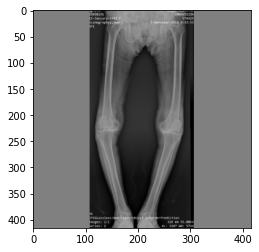

In [20]:
for epoch in range(start_epoch, epochs):
    yolov4.train()
    
    mloss = torch.zeros(4)
    for i, data in enumerate(train_dataloader):
        scheduler.step(
                    len(train_dataloader)
                    / (cfg.TRAIN["BATCH_SIZE"])
                    * epoch
                    + i
                )
        
        imgs = data[0]
        label_sbbox = data[1]
        label_mbbox = data[2]
        label_lbbox = data[3]
        sbboxes = data[4]
        mbboxes = data[5]
        lbboxes = data[6]
        
        imgs = imgs.to(device)
        label_sbbox = label_sbbox.to(device)
        label_mbbox = label_mbbox.to(device)
        label_lbbox = label_lbbox.to(device)
        sbboxes = sbboxes.to(device)
        mbboxes = mbboxes.to(device)
        lbboxes = lbboxes.to(device)
        
        input_img = np.transpose(imgs.squeeze(), (1, 2, 0))
        print(input_img.shape)
        plt.imshow(np.transpose(imgs.squeeze(), (1, 2, 0)))
        plt.show()
        
        
        p, p_d = yolov4(imgs)

        loss, loss_ciou, loss_conf, loss_cls = criterion(
            p,
            p_d,
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        loss_items = torch.tensor([loss_ciou, loss_conf, loss_cls, loss])
        mloss = (mloss * i + loss_items) / (i + 1)
        
#         print(f"epoch: {epoch}, mloss: {mloss}")
        if i%10 == 0:
            print(f"Epoch: {epoch}/{epochs}, step: [{i}/{len(train_dataloader) - 1}], mloss: {mloss}")
#             print(f"=== Epoch:[{epoch}/{epochs}], step:[{i}/{len(self.train_dataloader) - 1}], img_size:[{train_dataset.img_size:3}], total_loss:{mloss[3]:.4f}|loss_ciou:{mloss[0]:.4f}|loss_conf:{mloss[1]:.4f}|loss_cls:{mloss[2]:.4f}|lr:{optimizer.param_groups[0]["lr"]:.6f}")
        
        chkpt = {
            "epoch": epoch,
            # "best_mAP": self.best_mAP,
            "model": yolov4.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
#         torch.save(chkpt, 'model.pt')
